In [1]:
from geometry import Geometry3D
from sites import Site
import numpy as np
%matplotlib widget

In [2]:
from EQsystem import System

/opt/anaconda3/lib/python3.11/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [4]:
np.concatenate((np.arange(-1, 0, 0.1),np.arange(0,1,0.1)))

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [5]:
def density_function(r):
        spacing0 = 0.03  # spacing at r=0
        k = 1    # spacing increases by 0.05 per unit distance
        return spacing0 + k * r

    # Define a 3D simulation box: ((xmin, xmax), (ymin, ymax), (zmin, zmax))
    

In [6]:
testparams={"lattice_type": "square",   # or honeycomb_lattice, etc.
"box_size": ((-1.6, 1.6), (-3.1, 3.1), (-0.5, 0.5)),
"sampling_density_function": density_function,
"quantum_center": (0,0,0)     # optional, defaults to (0,0,0)
              }

In [7]:
syst=System(testparams,config_file="setup/setup_config1.json")

Generated 52811 points in 3D.
Voronoi cells have been created.
EQsystem is successfully initialized.


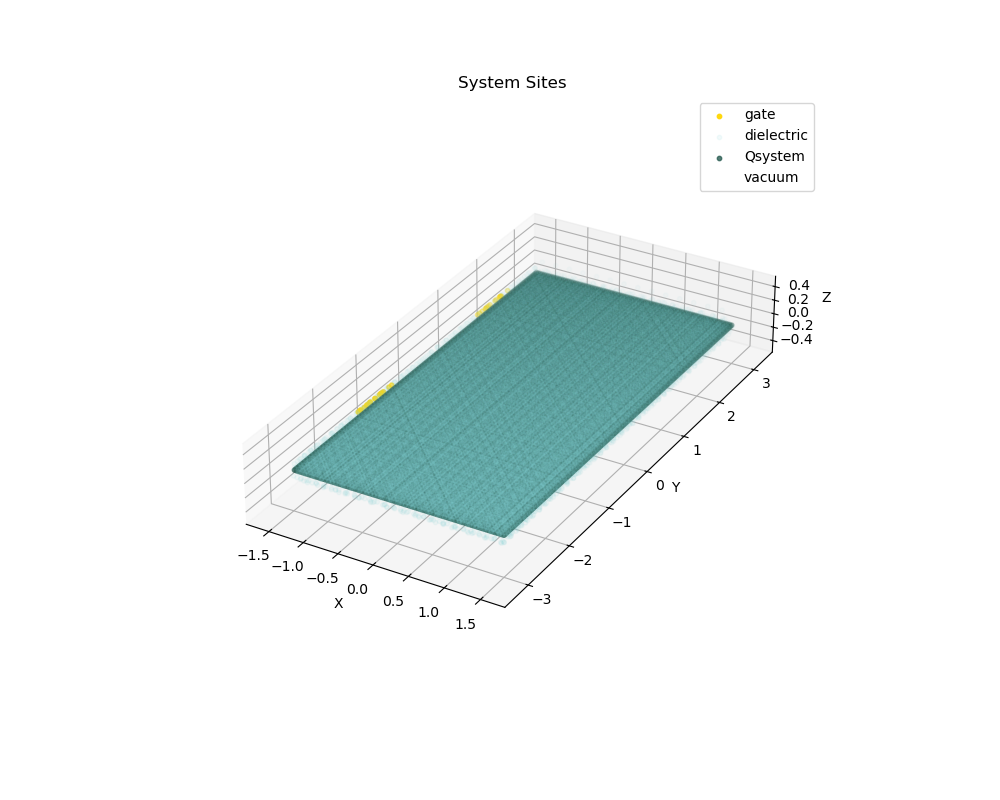

In [8]:
syst.plot_geometry()

In [19]:
import pyvista as pv
import numpy as np

def plot_voronoi_3d(vor):
    plotter = pv.Plotter()
    # The 3D Voronoi object contains regions that might not be closed.
    # Here we attempt to create surfaces from the finite regions.
    for region in vor.regions:
        if not region or -1 in region:
            continue
        # Create a PolyData object from the region vertices.
        region_points = vor.vertices[region]
        try:
            # Use Delaunay triangulation to form a surface.
            poly = pv.PolyData(region_points)
            surface = poly.delaunay_3d(alpha=1.0)
            if surface.n_cells > 0:
                plotter.add_mesh(surface, opacity=0.5, show_edges=True)
        except Exception as e:
            print("Failed to create a surface for a region:", e)
    
    # Add the original points for reference.
    plotter.add_points(vor.points, color="red", point_size=10)
    plotter.show()

# Example usage:
# vor = geometry3d.compute_voronoi()  # assuming geometry3d is an instance of your Geometry3D class.
# plot_voronoi_3d(vor)

In [ ]:
vor = geom3d.compute_voronoi()  # assuming geometry3d is an instance of your Geometry3D class.
plot_voronoi_3d(vor)

In [8]:
import pyvista as pv
pv.set_jupyter_backend('trame')

In [16]:
def polygon_area(vertices):
    """
    Compute the area of a planar convex polygon in 3D.
    
    This function triangulates the polygon using the first vertex as a reference.
    
    Parameters:
    - vertices: np.ndarray of shape (N,3) representing the polygon vertices in order.
    
    Returns:
    - area: float, the computed area of the polygon.
    """
    if len(vertices) < 3:
        return 0.0
    v0 = vertices[0]
    area = 0.0
    for i in range(1, len(vertices) - 1):
        v1 = vertices[i]
        v2 = vertices[i + 1]
        triangle_area = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
        area += triangle_area
    return area

In [17]:

def create_sites_from_geometry_3d(geometry3d):
    """
    Create Site objects from a Geometry3D instance.
    
    This function assumes that geometry3d.points is an array of shape (N, 3) and that
    geometry3d.compute_voronoi() has been called to obtain a 3D Voronoi tessellation.
    It then builds a dictionary of Site objects and populates neighbor relationships
    based on the Voronoi ridges.
    
    Parameters:
    - geometry3d: an instance of your Geometry3D class.
    
    Returns:
    - sites: dict mapping site IDs to Site objects.
    """
    # Get the points and the 3D Voronoi object.
    points = geometry3d.points  # shape (N, 3)
    vor = geometry3d.compute_voronoi()
    
    sites = {}
    num_points = len(points)
    for i in range(num_points):
        # Initialize each site with default values (modify as needed).
        sites[i] = Site(site_id=i, coordinates=points[i], charge=0.0, potential=0.0, dielectric_constant=1.0)
    
    # Use vor.ridge_points and vor.ridge_vertices to assign neighbor relationships.
    # Each ridge corresponds to a common face between two Voronoi cells.
    for ridge, ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        i, j = ridge
        # Skip infinite ridges (if any vertex is -1, it means the ridge is unbounded).
        if -1 in ridge_vertices:
            continue
        # Extract the vertices of the common face.
        face_vertices = vor.vertices[ridge_vertices]
        # Compute the area of the face.
        face_area = polygon_area(face_vertices)
        # Compute the distance between the two sites.
        distance = np.linalg.norm(sites[i].coordinates - sites[j].coordinates)
        # Add neighbor relationship for both sites.
        sites[i].add_neighbor(j, face_area)
        sites[j].add_neighbor(i, face_area)
    
    return sites

In [35]:
list(sites_dict.values())[1].neighbors

{5: 1.1805726928466331,
 10: 0.23232292003798374,
 4: 12.123026442523273,
 21: 38.32674936246214,
 28: 5.210133426222529,
 27: 2.482664655616283}

In [42]:
from pymumps import DMumpsContext

ModuleNotFoundError: No module named 'pymumps'